In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import scipy.sparse as sp
import yaml
import time
import gget
from itertools import combinations
import anndata as an
import scanpy as sc
import rapids_singlecell as rsc
from scipy.stats import median_abs_deviation
import scanpy.external as sce

import rmm
import cupy as cp
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=True,
    pool_allocator=False,
)
cp.cuda.set_allocator(rmm_cupy_allocator)

sc.settings.verbosity = 2

# Load in raw data

In [2]:
%%time

path = "/nfs/turbo/umms-indikar/shared/projects/hybrid_reprogramming/anndata/raw_merged_gene_data.h5ad"

adata_raw = sc.read_h5ad(path)

sc.logging.print_memory_usage() 

print(f"Initial shape: {adata_raw.shape}\n")
print(f"N cells in HYB dataset: {adata_raw[adata_raw.obs['dataset'] == 'Hybrid'].n_obs}")
print(f"N cells in scFib dataset: {adata_raw[adata_raw.obs['dataset'] == 'Control'].n_obs}\n")


### --- Handle HYB cells with NaN feature barcode predictions ---
init_cells_hybrid = adata_raw[adata_raw.obs['dataset'] == 'Hybrid'].n_obs

# remove HYB cells with NaN feature barcode predictions
hybrid_to_remove = (adata_raw.obs['dataset'] == 'Hybrid') & (adata_raw.obs['assigned_condition'].isna())
cells_to_keep = ~(hybrid_to_remove)
adata_raw = adata_raw[cells_to_keep].copy()

final_cells_hybrid = adata_raw[adata_raw.obs['dataset'] == 'Hybrid'].n_obs
removed_hybrid_cells = init_cells_hybrid - final_cells_hybrid

print(f"Removed {removed_hybrid_cells} 'Hybrid' cells with unassigned feature barcodes")



### --- Add new column for grouping HYB cells vs Controls ---
adata_raw.obs['pooled_condition'] = adata_raw.obs['assigned_condition'].replace({
    "G1": "Control",
    "S": "Control",
    "G2M": "Control",
    "PRRX1": "siPRRX1",
    "PRRX1_MYOD": "siPRRX1/mmMYOD1",
    "MYOD": "mmMYOD1"
})

# fill remaining NaN feature barcode predictions (only control cells) with 'Control'
adata_raw.obs['pooled_condition'] = adata_raw.obs['pooled_condition'].fillna('Control')
print(adata_raw.obs['pooled_condition'].value_counts())

print(f"Final shape: {adata_raw.shape}")
adata_raw

/nfs/turbo/umms-indikar/Jillian/conda-envs/rapids/lib/python3.13/site-packages/anndata/logging.py:57: FutureWarning: The specified parameters ('newline',) are no longer positional. Please specify them like `newline=False`
  print(format_memory_usage(get_memory_usage(), msg, newline))


Memory usage: current 1.30 GB, difference +1.30 GB
Initial shape: (19858, 28702)

N cells in HYB dataset: 10895
N cells in scFib dataset: 8963

Removed 1 'Hybrid' cells with unassigned feature barcodes
pooled_condition
Control            8963
siPRRX1/mmMYOD1    4174
siPRRX1            3955
mmMYOD1            2765
Name: count, dtype: int64
Final shape: (19857, 28702)
CPU times: user 339 ms, sys: 1 s, total: 1.34 s
Wall time: 2.66 s


<timed exec>:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.


AnnData object with n_obs × n_vars = 19857 × 28702
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End'

# Transfection efficiency

In [3]:
# tdata = adata_raw.copy()

# myod1_expr = tdata[:, 'MYOD1'].X.toarray().flatten()

# init_cells = tdata.n_obs

# remove_siPRRX1 = (tdata.obs['pooled_condition'] == 'siPRRX1') & (myod1_expr > 0)
# remove_mmMYOD1  = (tdata.obs['pooled_condition'] == 'mmMYOD1') & (myod1_expr == 0)
# remove_HYB  = (tdata.obs['pooled_condition'] == 'siPRRX1/mmMYOD1') & (myod1_expr == 0)

# # Combine both masks
# mask_remove = remove_siPRRX1 | remove_mmMYOD1 | remove_HYB

# # Keep only cells not in the mask
# tdata = tdata[~mask_remove].copy()

# # Final cell count
# final_cells = tdata.n_obs
# print(f"Removed {init_cells - final_cells} cells total:")
# print(f"  - {remove_siPRRX1.sum()} siPRRX1 cells with non-zero MYOD1 expression")
# print(f"  - {remove_mmMYOD1.sum()} mmMYOD1 cells with zero MYOD1 expression")
# print(f"  - {remove_HYB.sum()} siPRRX1/mmMYOD1 cells with zero MYOD1 expression")

# print(f"Final cells: {final_cells}")
# print(tdata.obs['pooled_condition'].value_counts())

Removed 1477 cells total:
  - 287 siPRRX1 cells with non-zero MYOD1 expression
  - 258 mmMYOD1 cells with zero MYOD1 expression
  - 932 siPRRX1/mmMYOD1 cells with zero MYOD1 expression
Final cells: 18380
pooled_condition
Control            8963
siPRRX1            3668
siPRRX1/mmMYOD1    3242
mmMYOD1            2507
Name: count, dtype: int64


In [18]:
# gene = 'PRRX1'
# prrx1_idx = tdata.var_names.get_loc(gene)

# # 2. Extract the PRRX1 column from the sparse matrix (returns a 2D sparse matrix)
# prrx1_values = tdata.X[:, prrx1_idx].toarray().ravel()  # convert to 1D np array

# # 3. Build the dataframe
# df = pd.DataFrame({
#     gene: prrx1_values,
#     'pooled_condition': tdata.obs['pooled_condition'].values
# }, index=tdata.obs_names)

# df.head()

PRRX1 pooled_condition
AAACCAAAGCAACTGC_hybrid    0.0  siPRRX1/mmMYOD1
AAACCAAAGTAGCCGT_hybrid    0.0  siPRRX1/mmMYOD1
AAACCAAAGTAGGGCA_hybrid    1.0          mmMYOD1
AAACCAAAGTCTAGGC_hybrid    1.0  siPRRX1/mmMYOD1
AAACCATTCACGTAAT_hybrid    0.0          siPRRX1

In [19]:
# df.groupby('pooled_condition', observed=True)[gene].describe()

count      mean       std  min  25%  50%  75%   max
pooled_condition                                                      
Control           8963.0  2.110008  2.237303  0.0  0.0  2.0  3.0  17.0
mmMYOD1           2507.0  1.083367  1.607243  0.0  0.0  0.0  2.0  15.0
siPRRX1           3668.0  0.703381  1.132517  0.0  0.0  0.0  1.0  10.0
siPRRX1/mmMYOD1   3242.0  0.427205  0.922368  0.0  0.0  0.0  1.0  11.0

In [13]:
# # how many cells with PRRX1 counts less than median in Control
# groups = ['Control', 'mmMYOD1', 'siPRRX1', 'siPRRX1/mmMYOD1']

# for g in groups:
#     tmp = df[df['pooled_condition'] == g]
    
#     print(f"{g}:")
#     print(f"\t N cells with PRRX1 counts less than control median: {tmp[tmp['PRRX1'] < 2.0].shape[0]}")
#     print(f"\t N cells with PRRX1 counts greater (or =) than control median: {tmp[tmp['PRRX1'] >= 2.0].shape[0]}")
#     print(f"\t N cells with 0 PRRX1 counts: {tmp[tmp['PRRX1'] == 0].shape[0]}")

Control:
	 N cells with PRRX1 counts less than control median: 4392
	 N cells with PRRX1 counts greater (or =) than control median: 4571
	 N cells with 0 PRRX1 counts: 2741
mmMYOD1:
	 N cells with PRRX1 counts less than control median: 1836
	 N cells with PRRX1 counts greater (or =) than control median: 671
	 N cells with 0 PRRX1 counts: 1265
siPRRX1:
	 N cells with PRRX1 counts less than control median: 3029
	 N cells with PRRX1 counts greater (or =) than control median: 639
	 N cells with 0 PRRX1 counts: 2207
siPRRX1/mmMYOD1:
	 N cells with PRRX1 counts less than control median: 2930
	 N cells with PRRX1 counts greater (or =) than control median: 312
	 N cells with 0 PRRX1 counts: 2402


# Remove unwanted cells

Removing cells from siPRRX1 only condition with positive MYOD1 expression 
<br>
Removing cells from mmMYOD1 only condition with zero MYOD1 expression

In [3]:
# Extract MYOD1 expression as a dense 1D array
myod1_expr = adata_raw[:, 'MYOD1'].X.toarray().flatten()

# Initial number of cells
init_cells = adata_raw.n_obs

### Create exclusion masks
# Remove siPRRX1 cells with positive MYOD expression
remove_siPRRX1 = (adata_raw.obs['pooled_condition'] == 'siPRRX1') & (myod1_expr > 0)
# Remove mmMYOD1 cells with zero MYOD expression
remove_mmMYOD1  = (adata_raw.obs['pooled_condition'] == 'mmMYOD1') & (myod1_expr == 0)
# # Remove HYB cells with zero MYOD expression
# remove_HYB  = (adata_raw.obs['pooled_condition'] == 'siPRRX1/mmMYOD1') & (myod1_expr == 0)

# Combine both masks
mask_remove = remove_siPRRX1 | remove_mmMYOD1 # | remove_HYB

# Keep only cells not in the mask
adata_raw = adata_raw[~mask_remove].copy()

# Final cell count
final_cells = adata_raw.n_obs
print(f"Removed {init_cells - final_cells} cells total:")
print(f"  - {remove_siPRRX1.sum()} siPRRX1 cells with non-zero MYOD1 expression")
print(f"  - {remove_mmMYOD1.sum()} mmMYOD1 cells with zero MYOD1 expression")
# print(f"  - {remove_HYB.sum()} siPRRX1/mmMYOD1 cells with zero MYOD1 expression")

print(f"Final cells: {final_cells}")
print(adata_raw.obs['pooled_condition'].value_counts())

Removed 545 cells total:
  - 287 siPRRX1 cells with non-zero MYOD1 expression
  - 258 mmMYOD1 cells with zero MYOD1 expression
Final cells: 19312
pooled_condition
Control            8963
siPRRX1/mmMYOD1    4174
siPRRX1            3668
mmMYOD1            2507
Name: count, dtype: int64


# QC and filtering

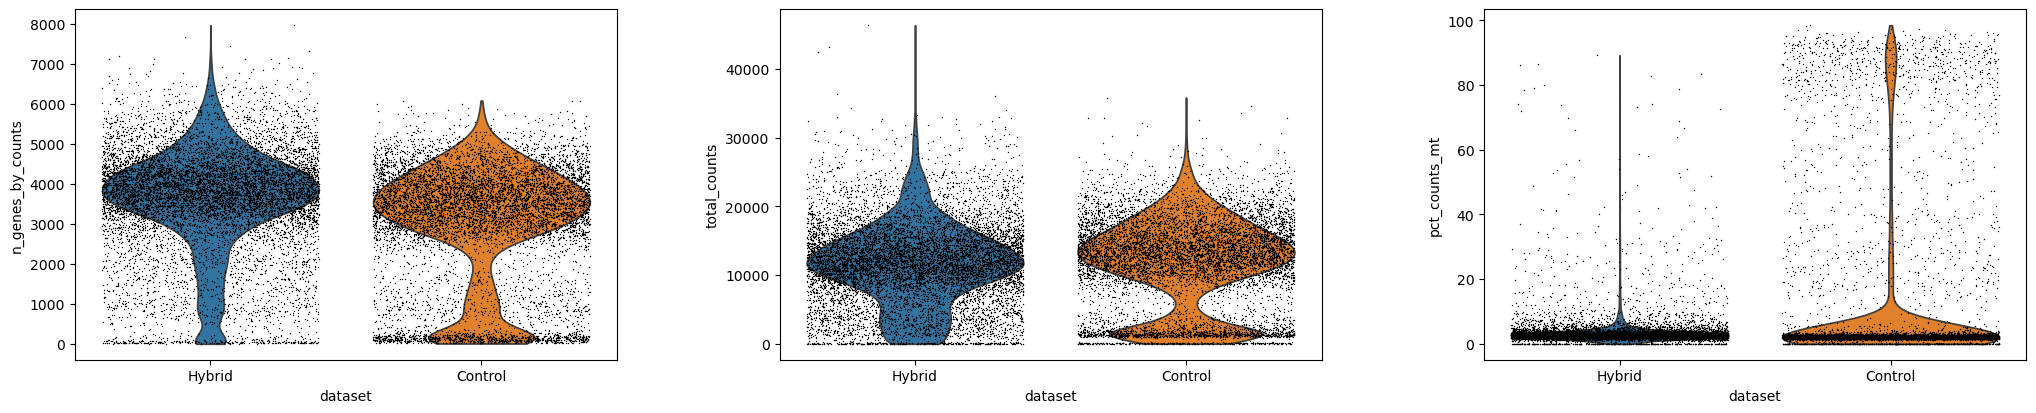

In [4]:
adata = adata_raw.copy()

# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], inplace=True, log1p=True)

plt.rcdefaults()
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    groupby='dataset',
)

## MAD filtering of low quality cells

MAD = Median absolute deviation

In [5]:
# Identify outlier cells with MADs per dataset
def is_outlier_by_group(adata, metric: str, nmads: int, group_col: str = 'dataset'):
    outlier_series = pd.Series(False, index=adata.obs.index)
    unique_groups = adata.obs[group_col].unique()

    for group in unique_groups:
        group_mask = (adata.obs[group_col] == group)
        M_group = adata.obs.loc[group_mask, metric]

        if len(M_group) < 2 or M_group.isnull().all():
            continue

        median_val_group = np.median(M_group)
        mad_val_group = median_abs_deviation(M_group)

        if mad_val_group == 0:
            continue

        outliers_in_group = (M_group < median_val_group - nmads * mad_val_group) | \
                            (median_val_group + nmads * mad_val_group < M_group)

        outlier_series.loc[group_mask] = outliers_in_group

    return outlier_series

### determine outliers
adata.obs["outlier"] = (
    is_outlier_by_group(adata, "log1p_total_counts", 5, 'dataset')
    | is_outlier_by_group(adata, "log1p_n_genes_by_counts", 5, 'dataset')
)

print("Number of outlier cells per dataset based on counts:")
print(adata.obs.groupby('dataset', observed=True)['outlier'].sum())


adata.obs["mt_outlier"] = is_outlier_by_group(adata, "pct_counts_mt", 5, 'dataset') | (
    adata.obs["pct_counts_mt"] > 20
)

print("\nNumber of outlier cells per dataset based on pct mito:")
adata.obs.groupby('dataset', observed=True)['mt_outlier'].sum()


### remove outliers
init_cells = adata.n_obs
init_cells_hyb = adata[adata.obs['dataset'] == 'Hybrid'].n_obs
init_cells_fib = adata[adata.obs['dataset'] == 'Control'].n_obs

print(f"Total number of cells: {init_cells}")
print(f"N cells in Hybird: {init_cells_hyb}")
print(f"N cells in Control: {init_cells_fib}")

print(f"\nFiltering...")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

final_cells = adata.n_obs
final_cells_hyb = adata[adata.obs['dataset'] == 'Hybrid'].n_obs
final_cells_fib = adata[adata.obs['dataset'] == 'Control'].n_obs

print(f"\nRemoved {init_cells - final_cells} total cells.")
print(f"Removed {init_cells_hyb - final_cells_hyb} from Hybrid dataset.")
print(f"Removed {init_cells_fib - final_cells_fib} from Control dataset.")

print(f"\nTotal cells after filtering of low quality cells: {final_cells}")
print(f"N cells in Hybird: {final_cells_hyb}")
print(f"N cells in Control: {final_cells_fib}")

Number of outlier cells per dataset based on counts:
dataset
Hybrid     1058
Control    1676
Name: outlier, dtype: int64

Number of outlier cells per dataset based on pct mito:
Total number of cells: 19312
N cells in Hybird: 10349
N cells in Control: 8963

Filtering...

Removed 3353 total cells.
Removed 1350 from Hybrid dataset.
Removed 2003 from Control dataset.

Total cells after filtering of low quality cells: 15959
N cells in Hybird: 8999
N cells in Control: 6960


In [17]:
adata.obs.groupby('dataset')['mt_outlier'].value_counts()

/tmp/ipykernel_3872934/3199811779.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('dataset')['mt_outlier'].value_counts()


dataset  mt_outlier
Hybrid   False         8999
Control  False         6960
Name: count, dtype: int64

# Gene filtering and normalization

In [6]:
# keep full dimension safe
adata.raw = adata  

# save raw counts
adata.layers['raw_counts'] = adata.X.copy()

print("Filtering genes...\n")

sc.pp.filter_genes(adata, min_counts=10)

print("\nNormalizing counts to 10,000...\n")
sc.pp.normalize_total(
    adata,
    target_sum=1e4,
)

# log transform normalized counts
sc.pp.log1p(adata)

# save log normalized counts
adata.layers['log_norm'] = adata.X.copy()

adata

Filtering genes...

filtered out 3660 genes that are detected in less than 10 counts

Normalizing counts to 10,000...

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 15959 × 25042
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    uns: 'dataset_colors', 'log1p'
    layers: 'raw_counts', 'log_norm'

# Score cell cycle genes

In [7]:
%%time
regev_genes = [x.strip() for x in open('../../resources/regev_lab_cell_cycle_genes.txt')]
s_genes = regev_genes[:43]
g2m_genes = regev_genes[43:]

sc.tl.score_genes_cell_cycle(
    adata,
    s_genes=s_genes,
    g2m_genes=g2m_genes,
)

adata.obs[['phase']].head()

calculating cell cycle phase
computing score 'S_score'
    finished (0:00:01)
computing score 'G2M_score'
    finished (0:00:01)
CPU times: user 1.71 s, sys: 1.18 s, total: 2.89 s
Wall time: 2.97 s


phase
AAACCAAAGCAACTGC_hybrid   G2M
AAACCAAAGTAGGGCA_hybrid     S
AAACCAAAGTCTAGGC_hybrid    G1
AAACCATTCACGTAAT_hybrid   G2M
AAACCATTCAGGCAGA_hybrid   G2M

# Dimension reduction

In [8]:
gdf = adata.var[['gene_type']].copy()
gdf = gdf.reset_index(names='names')

protein_coding = gdf[gdf['gene_type'] == 'protein_coding']['names'].unique()
print(len(protein_coding))


adata.var['filter_pass'] = True # set the gene filter

# pt genes only
adata.var['filter_pass'] = np.where(~adata.var.index.isin(protein_coding), False, adata.var['filter_pass'])

# disallow GO cell cycle genes
fpath = "../../resources/human_cell_cycle_genes.csv"
cdf = pd.read_csv(fpath)
adata.var['filter_pass'] = np.where(adata.var.index.isin(cdf['gene_name'].unique()), False, adata.var['filter_pass'])

# disallow Regev cell cycle genes
fpath = "../../resources/regev_lab_cell_cycle_genes.txt"
genes = [x.strip() for x in open(fpath)]
adata.var['filter_pass'] = np.where(adata.var.index.isin(genes), False, adata.var['filter_pass'])

# disallow mitochondrial and ribosomal genes
adata.var['filter_pass'] = np.where(adata.var.index.str.startswith('MT'), False, adata.var['filter_pass'])
adata.var['filter_pass'] = np.where(adata.var.index.str.startswith('RP'), False, adata.var['filter_pass'])

print(adata.var['filter_pass'].value_counts().to_string())

15786
filter_pass
True     15357
False     9685


extracting highly variable genes
Number of HVG: 2000


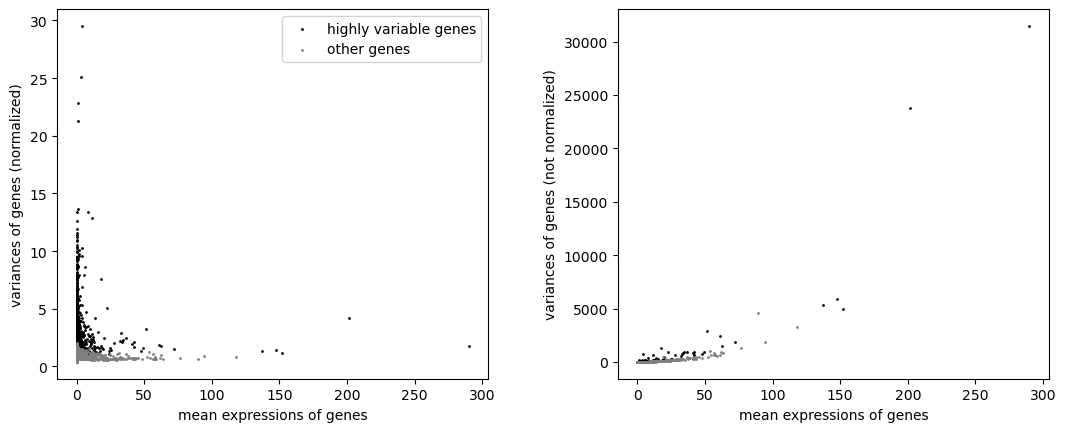

computing PCA
    with n_comps=50
    finished (0:00:22)


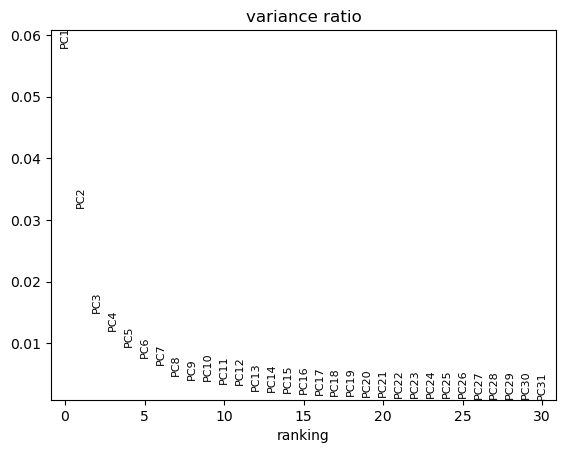

... storing 'phase' as categorical


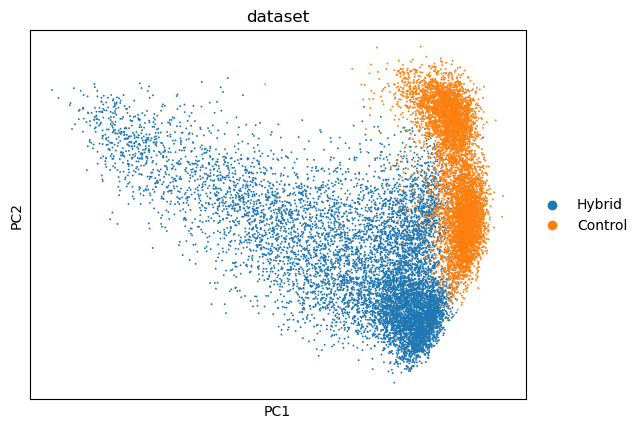

AnnData object with n_obs × n_vars = 15959 × 25042
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'filter_pass', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'hi

In [9]:
### HVGs
adata.X = adata.layers['raw_counts'].copy()

sc.pp.highly_variable_genes(
    adata,
    flavor='seurat_v3',
    batch_key='dataset',
)

print(f"Number of HVG: {adata.var['highly_variable'].sum()}")

plt.rcdefaults()
sc.pl.highly_variable_genes(adata)

adata.X = adata.layers['log_norm'].copy()

### PCA with 'filter_pass' genes
sc.pp.pca(
    adata,
    mask_var='filter_pass',
)

sc.pl.pca_variance_ratio(adata)
sc.pl.pca(adata, color='dataset')

adata

# Harmony integration

2025-11-17 11:58:44,087 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-11-17 11:58:44 | [INFO] Computing initial centroids with sklearn.KMeans...
2025-11-17 11:58:47,256 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-11-17 11:58:47 | [INFO] sklearn.KMeans initialization complete.
2025-11-17 11:58:47,332 - harmonypy - INFO - Iteration 1 of 10
2025-11-17 11:58:47 | [INFO] Iteration 1 of 10
2025-11-17 11:58:50,521 - harmonypy - INFO - Iteration 2 of 10
2025-11-17 11:58:50 | [INFO] Iteration 2 of 10
2025-11-17 11:58:53,702 - harmonypy - INFO - Converged after 2 iterations
2025-11-17 11:58:53 | [INFO] Converged after 2 iterations


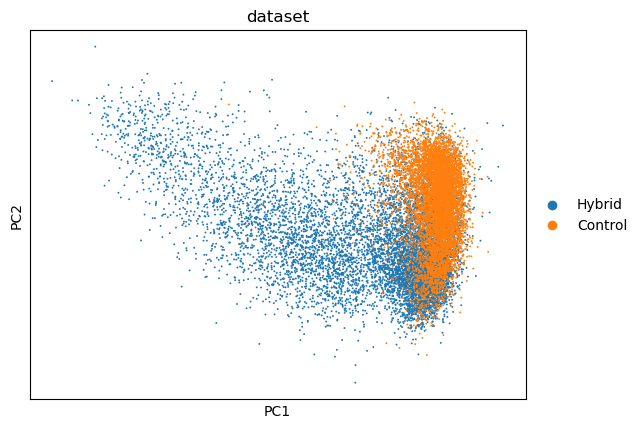

In [10]:
bdata = adata.copy()

### Harmony integration
sce.pp.harmony_integrate(bdata, key=['dataset', 'phase'])

# Save original PCA space
bdata.obsm["X_pca_original"] = bdata.obsm["X_pca"].copy()

# Set Harmony-corrected PCA as the default for plotting
bdata.obsm["X_pca"] = bdata.obsm["X_pca_harmony"].copy()

sc.pl.pca(bdata, color='dataset')

# Neighbors and UMAP

running Leiden clustering
    finished (0:00:00)


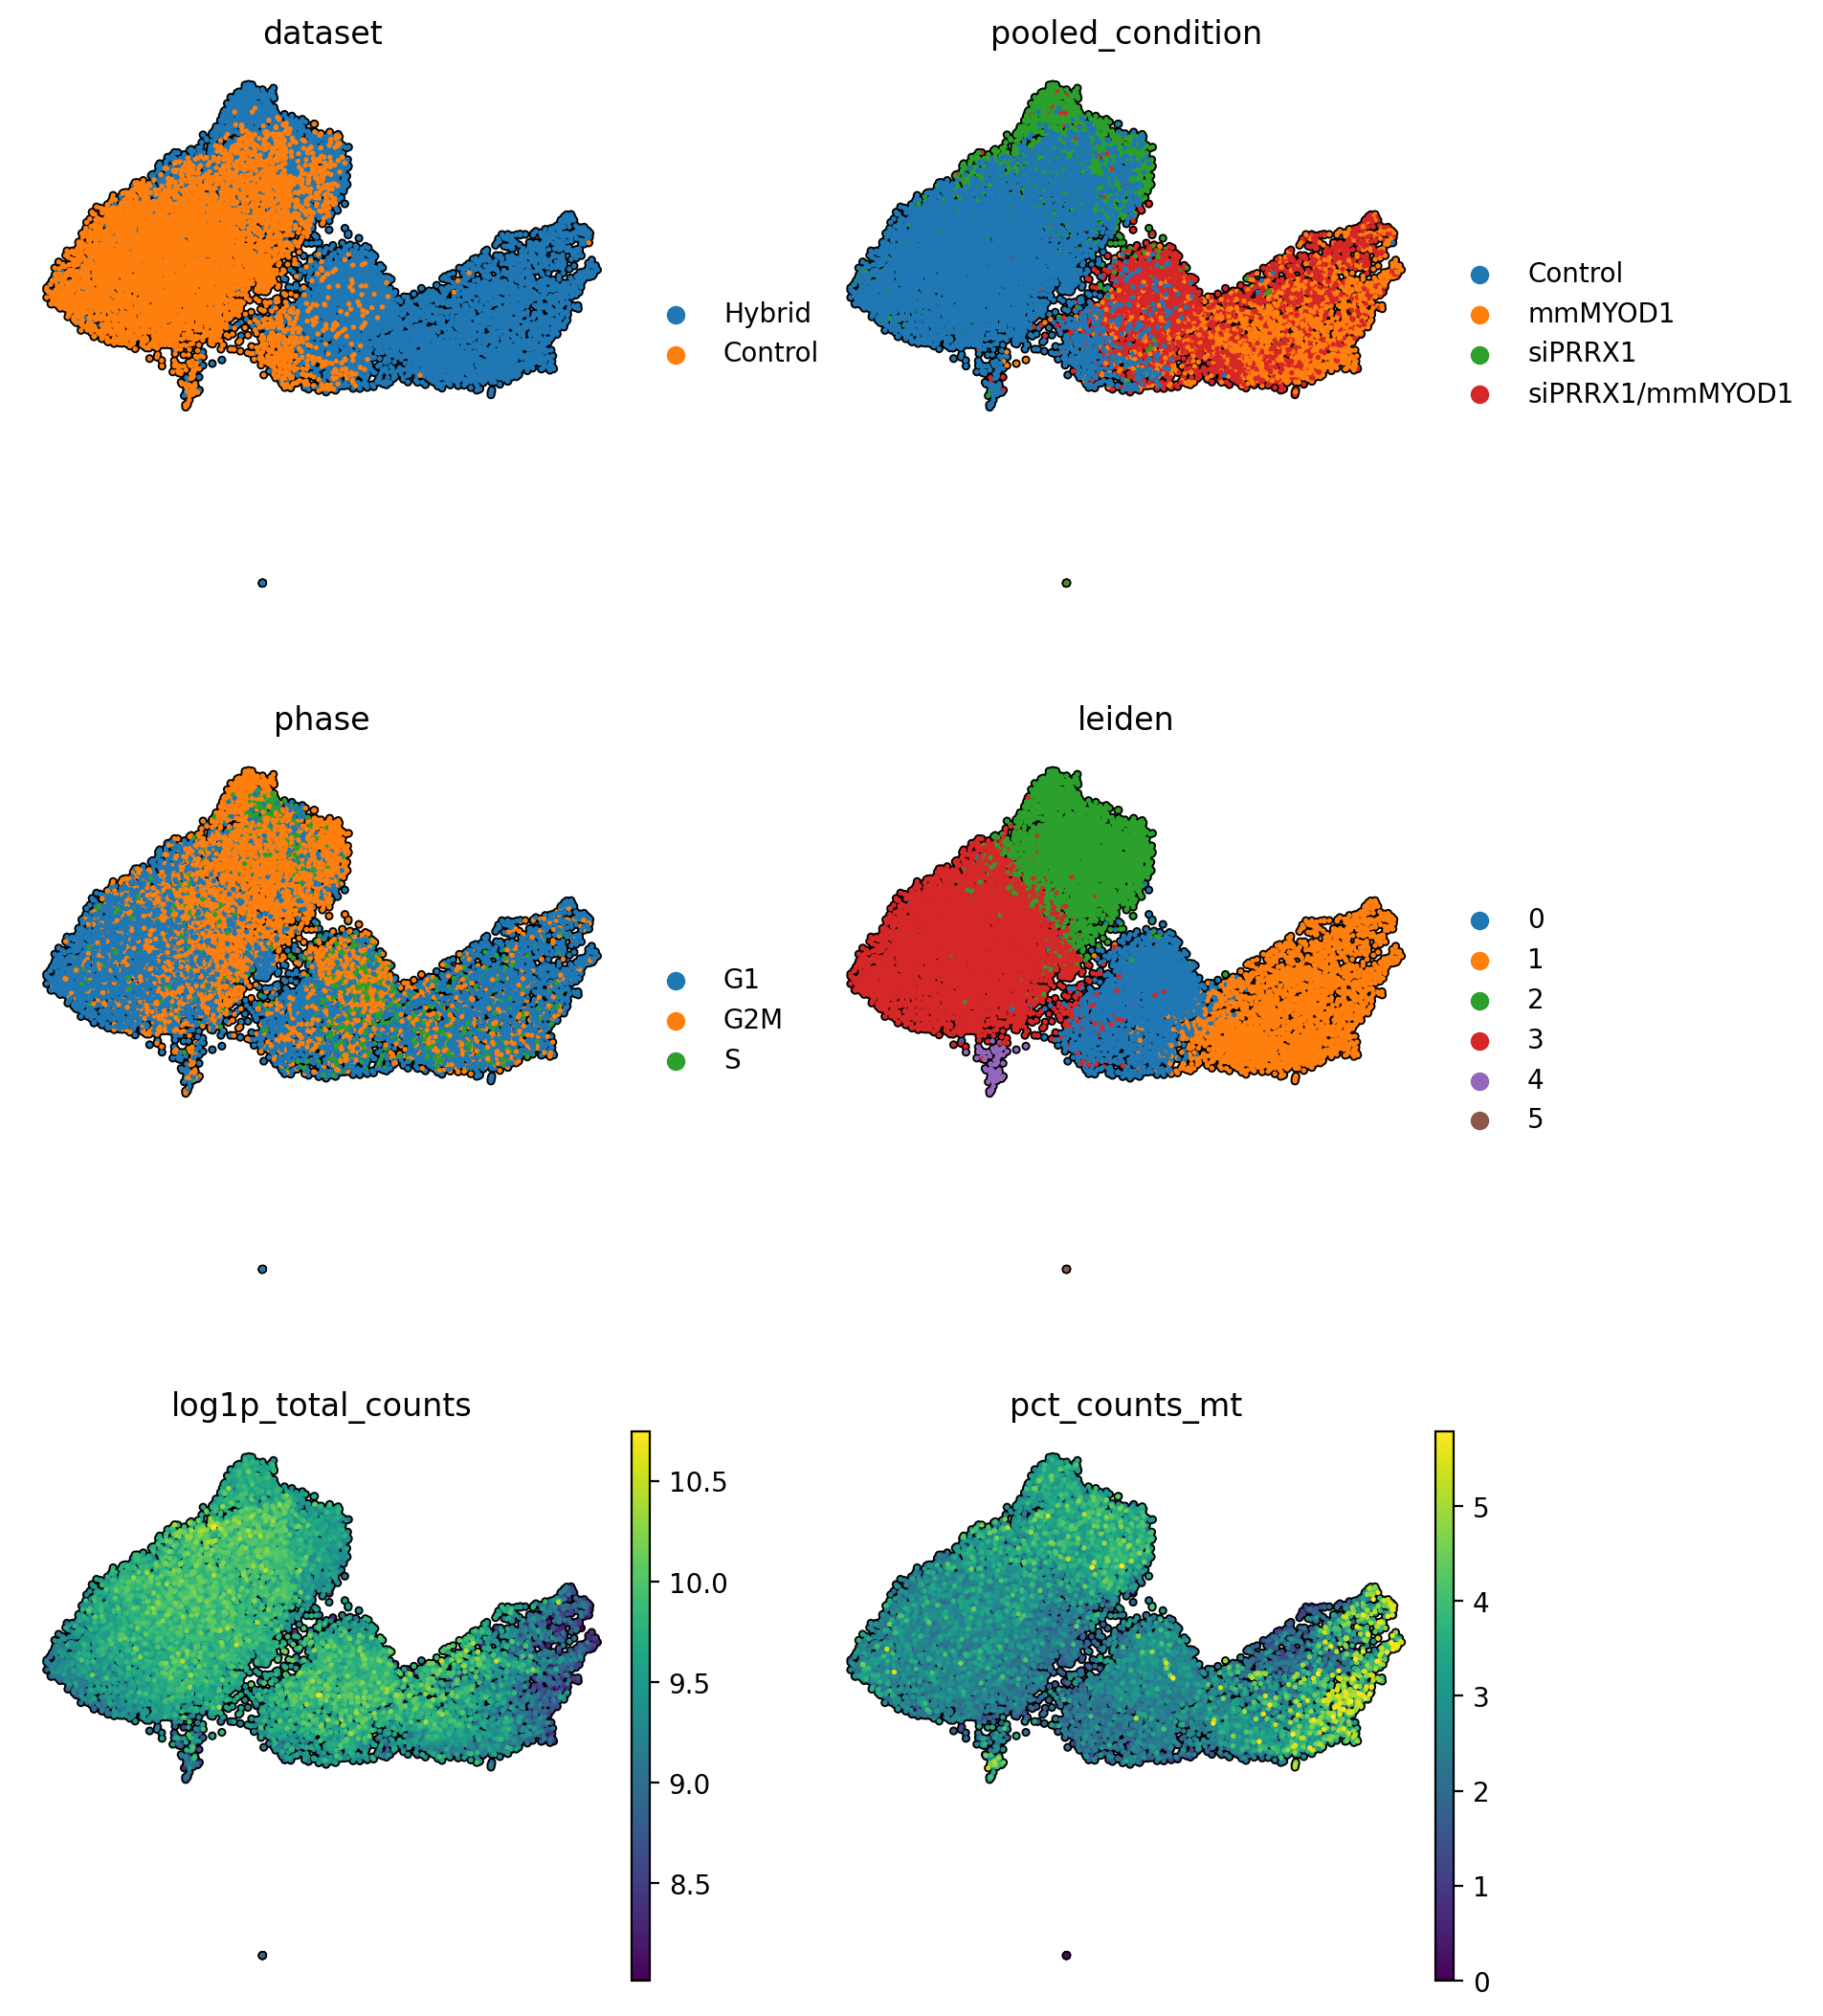

In [11]:
rsc.get.anndata_to_GPU(bdata)

rsc.pp.neighbors(
    bdata,
    use_rep='X_pca_harmony',
    n_neighbors=5, # 5 for OG, 10 for new
)

rsc.tl.umap(
    bdata,
    min_dist=0.4, # 0.4 for OG, 0.2 for new
    # spread=1.2,
)

rsc.get.anndata_to_CPU(bdata)

sc.tl.leiden(
    bdata,
    resolution=0.3,
    flavor='igraph',
)

plt.rcdefaults()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.umap(
    bdata,
    color=['dataset', 'pooled_condition', 'phase', 'leiden', 'log1p_total_counts', 'pct_counts_mt'],
    size=15,
    ncols=2,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    alpha=1,
)

In [12]:
bdata.obs['cluster_str'] = bdata.obs['leiden'].apply(lambda x: f"C{str(int(x) + 1)}")

bdata.obs['cluster_str'].value_counts()

cluster_str
C4    6482
C3    3554
C2    3100
C1    2720
C5      94
C6       9
Name: count, dtype: int64

In [13]:
clusters_to_remove = ['C6']

bdata = bdata[~bdata.obs['cluster_str'].isin(clusters_to_remove)]

print(bdata.obs['cluster_str'].value_counts())

cluster_str
C4    6482
C3    3554
C2    3100
C1    2720
C5      94
Name: count, dtype: int64


# Sub-cluster per condition

computing neighbors
    finished (0:00:05)
running Leiden clustering
    finished (0:00:00)
computing neighbors
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)
computing neighbors
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)
computing neighbors
    finished (0:00:00)
running Leiden clustering
    finished (0:00:00)


... storing 'leiden_split' as categorical


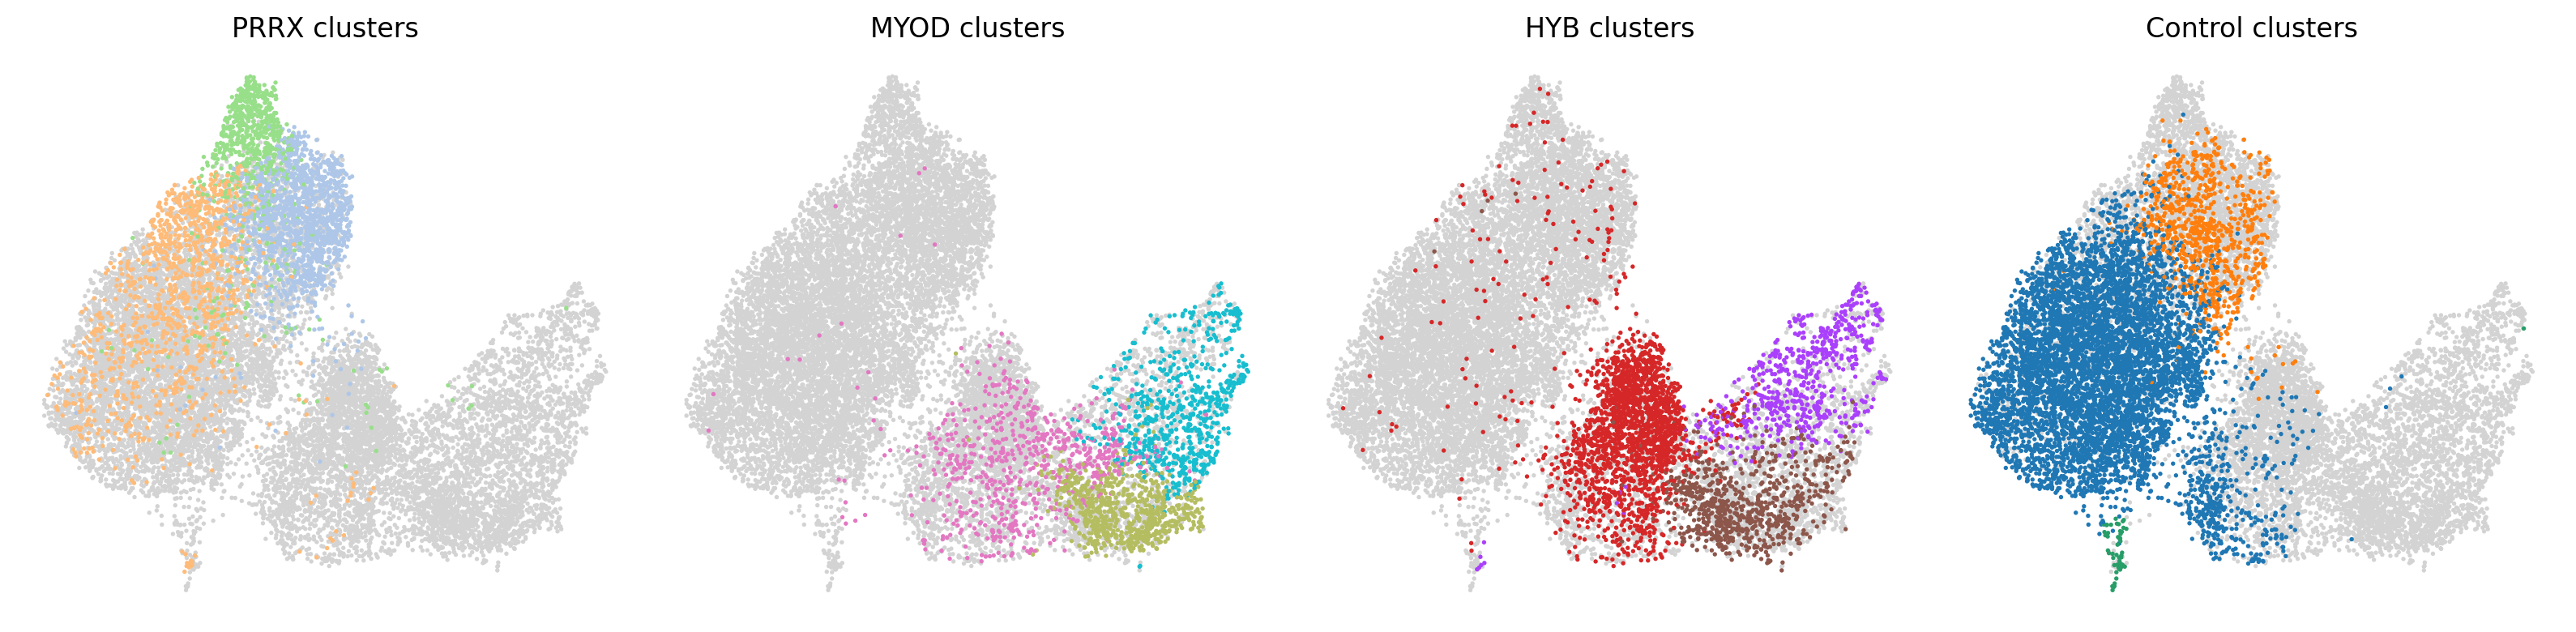

In [14]:
## OG
# myod_res = 0.25
# prrx_res = 0.25
# hyb_res = 0.25
# ctrl_res = 0.2

myod_res = 0.25
prrx_res = 0.25
hyb_res = 0.25
ctrl_res = 0.2

# Cluster mmMYOD1 cells separately from controls
subset_myod = bdata[bdata.obs['pooled_condition'] == 'mmMYOD1'].copy()
sc.pp.neighbors(subset_myod, n_neighbors=10, use_rep='X_pca_harmony')
sc.tl.leiden(subset_myod, resolution=myod_res, flavor='igraph')

subset_hyb = bdata[bdata.obs['pooled_condition'] == 'siPRRX1/mmMYOD1'].copy()
sc.pp.neighbors(subset_hyb, n_neighbors=10, use_rep='X_pca_harmony')
sc.tl.leiden(subset_hyb, resolution=hyb_res, flavor='igraph')

subset_prrx = bdata[bdata.obs['pooled_condition'] == 'siPRRX1'].copy()
sc.pp.neighbors(subset_prrx, n_neighbors=10, use_rep='X_pca_harmony')
sc.tl.leiden(subset_prrx, resolution=prrx_res, flavor='igraph')


subset_ctrl = bdata[bdata.obs['pooled_condition'] == 'Control'].copy()
sc.pp.neighbors(subset_ctrl, n_neighbors=10, use_rep='X_pca_harmony')
sc.tl.leiden(subset_ctrl, resolution=ctrl_res, flavor='igraph')



# Add back to adata as one group
bdata.obs['leiden_split'] = None
bdata.obs.loc[subset_myod.obs_names, 'leiden_split'] = ('M' + (subset_myod.obs['leiden'].astype(int) + 1).astype(str))
bdata.obs.loc[subset_hyb.obs_names, 'leiden_split'] = ('H' + (subset_hyb.obs['leiden'].astype(int) + 1).astype(str))
bdata.obs.loc[subset_prrx.obs_names, 'leiden_split'] = ('P' + (subset_prrx.obs['leiden'].astype(int) + 1).astype(str))
bdata.obs.loc[subset_ctrl.obs_names, 'leiden_split'] = ('C' + (subset_ctrl.obs['leiden'].astype(int) + 1).astype(str))


# plotting 
mask_prrx = bdata.obs['leiden_split'].str.startswith('P')
mask_myod = bdata.obs['leiden_split'].str.startswith('M')
mask_hyb = bdata.obs['leiden_split'].str.startswith('H')
mask_ctrl = bdata.obs['leiden_split'].str.startswith('C')

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

sc.pl.umap(
    bdata,
    color='leiden_split',
    mask_obs=mask_prrx,
    size=15,
    frameon=False,
    alpha=1,
    ax=axes[0],
    show=False,
    title="PRRX clusters",
    legend_loc='none',
)

sc.pl.umap(
    bdata,
    color='leiden_split',
    mask_obs=mask_myod,
    size=15,
    frameon=False,
    alpha=1,
    ax=axes[1],
    show=False,
    title="MYOD clusters",
    legend_loc='none',
)

sc.pl.umap(
    bdata,
    color='leiden_split',
    mask_obs=mask_hyb,
    size=15,
    frameon=False,
    alpha=1,
    ax=axes[2],
    show=False,
    title="HYB clusters",
    legend_loc='none',
)

sc.pl.umap(
    bdata,
    color='leiden_split',
    mask_obs=mask_ctrl,
    size=15,
    frameon=False,
    alpha=1,
    ax=axes[3],
    show=False,
    title="Control clusters",
    legend_loc='none',
)

plt.tight_layout()
plt.show()

['#393b79',
 '#5254a3',
 '#9c9ede',
 '#8ca252',
 '#cedb9c',
 '#bd9e39',
 '#e7ba52',
 '#843c39',
 '#d6616b',
 '#7b4173',
 '#ce6dbd',
 '#de9ed6']

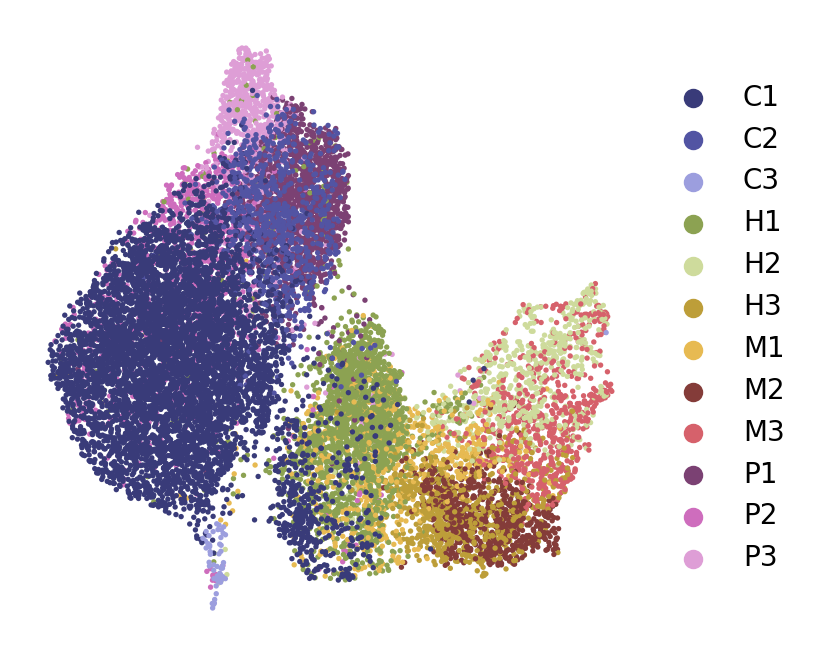

In [27]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.umap(
    bdata,
    color='leiden_split',
    size=15,
    frameon=False,
    alpha=1,
    palette='tab20b',
    show=False,
    title='',
    # legend_loc='on data',
)

bdata.uns['leiden_split_colors'] = sc.pl.palettes.default_20 if 'leiden_split_colors' not in bdata.uns else bdata.uns['leiden_split_colors']
bdata.uns['leiden_split_colors'] 

/tmp/ipykernel_1735370/364432014.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  bdata.obs['leiden_split'] = bdata.obs['leiden_split'].replace({'H3': 'TEMP_SWAP', 'H2': 'H3'})
/tmp/ipykernel_1735370/364432014.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  bdata.obs['leiden_split'] = bdata.obs['leiden_split'].replace('TEMP_SWAP', 'H2')
/tmp/ipykernel_1735370/364432014.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the cat

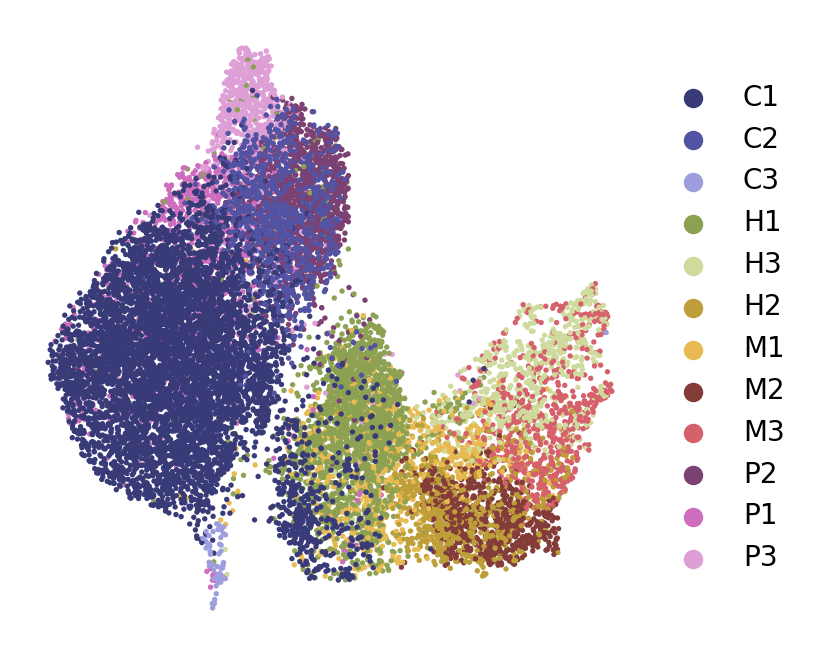

In [28]:
bdata.obs['leiden_split'] = bdata.obs['leiden_split'].replace({'H3': 'TEMP_SWAP', 'H2': 'H3'})
bdata.obs['leiden_split'] = bdata.obs['leiden_split'].replace('TEMP_SWAP', 'H2')

bdata.obs['leiden_split'] = bdata.obs['leiden_split'].replace({'P1': 'TEMP_SWAP', 'P2': 'P1'})
bdata.obs['leiden_split'] = bdata.obs['leiden_split'].replace('TEMP_SWAP', 'P2')

sc.pl.umap(
    bdata,
    color='leiden_split',
    size=15,
    frameon=False,
    alpha=1,
    title='',
)

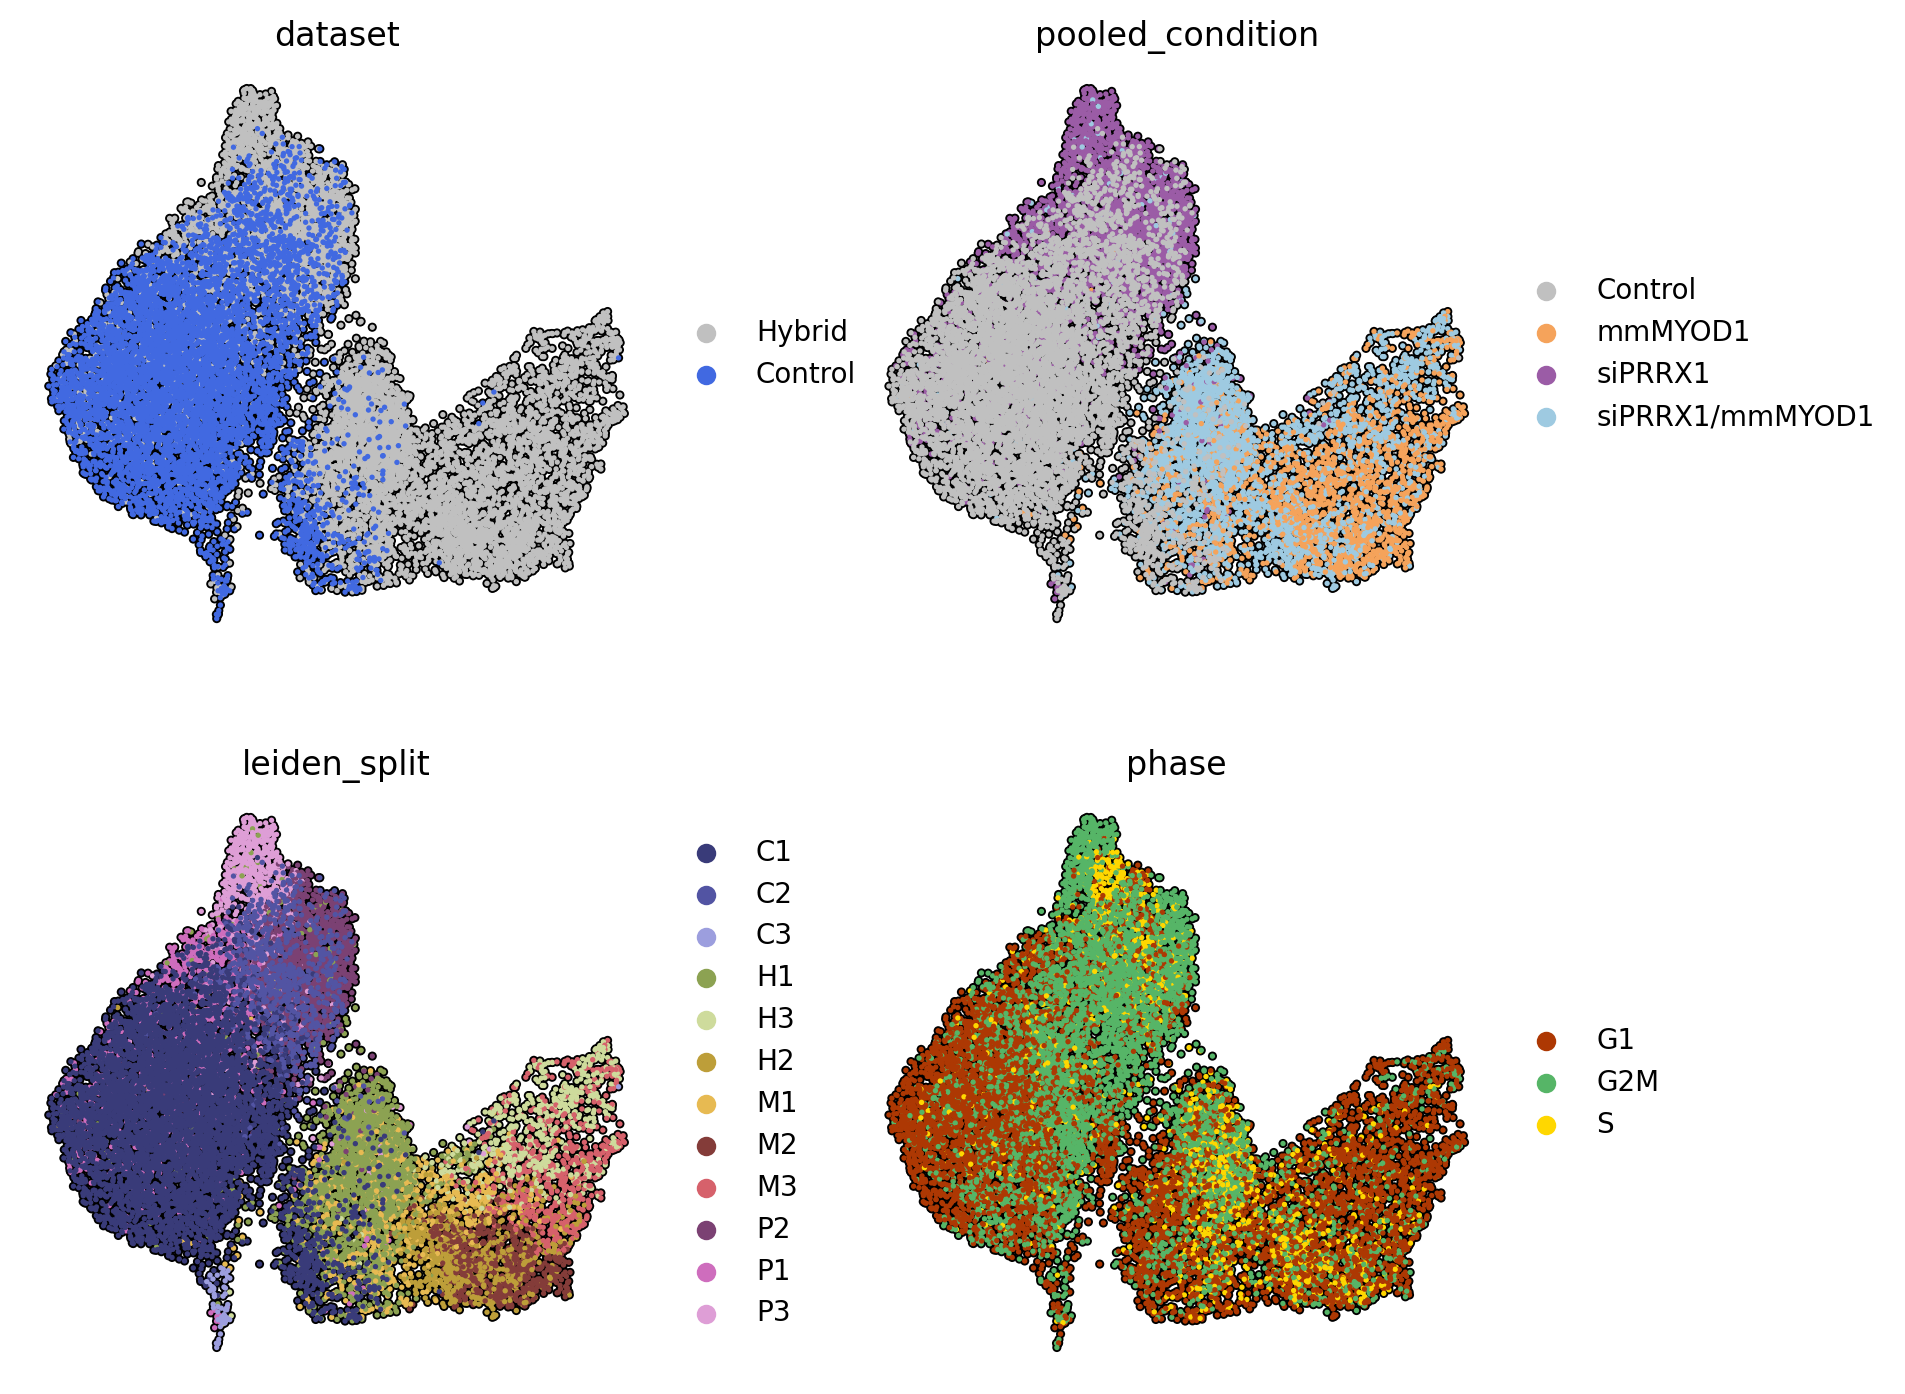

In [30]:
# cluster_colors = [
#     "#E2514A",
#     "#FCA55D",
#     "#FEE99B",
#     "#439BB5",
#     "#90D2A4",
#     # "#439BB5",
# ]
# bdata.uns['cluster_str_colors'] = cluster_colors

bdata.uns['dataset_colors'] = ["silver", "royalblue"]

phase_colors = ['#ad3803', '#56b567', 'gold']
bdata.uns['phase_colors'] = phase_colors

condition_colors = ['silver', "#F5A35B", "#9B5CA6", "#9ECAE1"]
bdata.uns['pooled_condition_colors'] = condition_colors

sc.pl.umap(
    bdata,
    color=['dataset', 'pooled_condition', 'leiden_split', 'phase'],
    size=15,
    ncols=2,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    alpha=1,
)

In [32]:
bdata.write("/nfs/turbo/umms-indikar/shared/projects/hybrid_reprogramming/anndata/processed_all_groups.h5ad")
bdata

AnnData object with n_obs × n_vars = 15950 × 25042
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str', 'leiden_split'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'filter_pass', 'highly_variable', 'highly_variable_rank', 'm